## **Problem Statement**

### Business Context

The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

### Problem Definition

With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.

As a member of the Data Science and AI team in the startup, you have been tasked with analyzing the data, developing an AI-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

### Data Dictionary

* `Date` : The date the news was released
* `News` : The content of news articles that could potentially affect the company's stock price
* `Open` : The stock price (in \$) at the beginning of the day
* `High` : The highest stock price (in \$) reached during the day
* `Low` :  The lowest stock price (in \$) reached during the day
* `Close` : The adjusted stock price (in \$) at the end of the day
* `Volume` : The number of shares traded during the day
* `Label` : The sentiment polarity of the news content
    * 1: positive
    * 0: neutral
    * -1: negative

## **Installing and Importing Necessary Libraries**

In [2]:
# installing the sentence-transformers and gensim libraries for word embeddings
!pip install -U sentence-transformers gensim transformers tqdm -q

In [1]:
# to read and manipulate the data
import pandas as pd
import numpy as np
pd.set_option('max_colwidth', None)    # setting column to the maximum column width as per the data

# to visualise data
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# to use regular expressions for manipulating text data
import re

# to load the natural language toolkit
import nltk
nltk.download('stopwords')    # loading the stopwords
nltk.download('wordnet')    # loading the wordnet module that is used in stemming

# to remove common stop words
from nltk.corpus import stopwords

# to perform stemming
from nltk.stem.porter import PorterStemmer

# To import Word2Vec
from gensim.models import Word2Vec

# To import SentenceTransformer
from sentence_transformers import SentenceTransformer

import torch

# To tune the model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.linear_model import LogisticRegression


# Converting the Stanford GloVe model vector format to word2vec
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

# To split data into train and test sets
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## **Loading the dataset**

In [ ]:
df = pd.read_csv("/content/sample_data/stock_news.csv")

## **Data Overview**

In [ ]:
print("Rows:", len(df))
df.head()

Rows: 349


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    349 non-null    object 
 1   News    349 non-null    object 
 2   Open    349 non-null    float64
 3   High    349 non-null    float64
 4   Low     349 non-null    float64
 5   Close   349 non-null    float64
 6   Volume  349 non-null    int64  
 7   Label   349 non-null    int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 21.9+ KB


In [ ]:
df.shape

(349, 8)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date').reset_index(drop=True)

In [ ]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349 entries, 0 to 348
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    349 non-null    datetime64[ns]
 1   News    349 non-null    object        
 2   Open    349 non-null    float64       
 3   High    349 non-null    float64       
 4   Low     349 non-null    float64       
 5   Close   349 non-null    float64       
 6   Volume  349 non-null    int64         
 7   Label   349 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 21.9+ KB


(349, 8)

In [ ]:
df.describe()

,Date,Open,High,Low,Close,Volume,Label
count,349,349.000000,349.000000,349.000000,349.000000,3.490000e+02,349.000000
mean,2019-02-16 16:05:30.085959936,46.229233,46.700458,45.745394,44.926317,1.289482e+08,-0.054441
min,2019-01-02 00:00:00,37.567501,37.817501,37.305000,36.254131,4.544800e+07,-1.000000
25%,2019-01-14 00:00:00,41.740002,42.244999,41.482498,40.246914,1.032720e+08,-1.000000
50%,2019-02-05 00:00:00,45.974998,46.025002,45.639999,44.596924,1.156272e+08,0.000000
75%,2019-03-22 00:00:00,50.707500,50.849998,49.777500,49.110790,1.511252e+08,0.000000
max,2019-04-30 00:00:00,66.817497,67.062500,65.862503,64.805229,2.444392e+08,1.000000
std,NaN,6.442817,6.507321,6.391976,6.398338,4.317031e+07,0.715119


In [ ]:
expected_cols = {'Date','News','Open','High','Low','Close','Volume','Label'}
missing = expected_cols - set(df.columns)
assert not missing, f"Missing required columns: {missing}"

### Missing *Values*

In [ ]:
df.isnull().sum()

,0
Date,0
News,0
Open,0
High,0
Low,0
Close,0
Volume,0
Label,0


- There are no mising values in the data

### Duplicate *Values*

In [ ]:
# checking for duplicate values
df.duplicated().sum()

0

- There are no duplicate values in the dataset.

## **Exploratory Data Analysis**

### Univariate Analysis

- Daily price/volume distributions
- News length distribution
- Label class balance

,Open,High,Low,Close,Volume
count,349.000000,349.000000,349.000000,349.000000,3.490000e+02
mean,46.229233,46.700458,45.745394,44.926317,1.289482e+08
std,6.442817,6.507321,6.391976,6.398338,4.317031e+07
min,37.567501,37.817501,37.305000,36.254131,4.544800e+07
25%,41.740002,42.244999,41.482498,40.246914,1.032720e+08
50%,45.974998,46.025002,45.639999,44.596924,1.156272e+08
75%,50.707500,50.849998,49.777500,49.110790,1.511252e+08
max,66.817497,67.062500,65.862503,64.805229,2.444392e+08


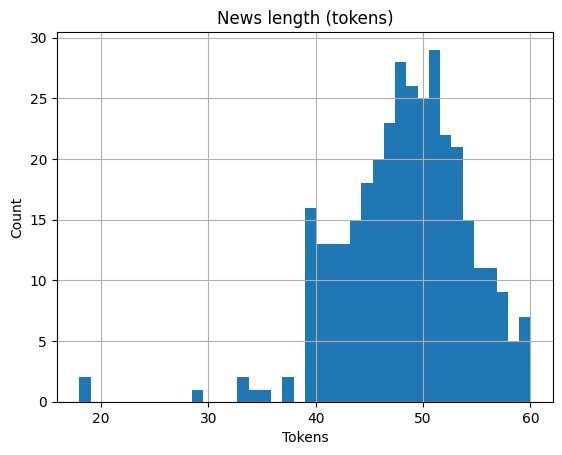

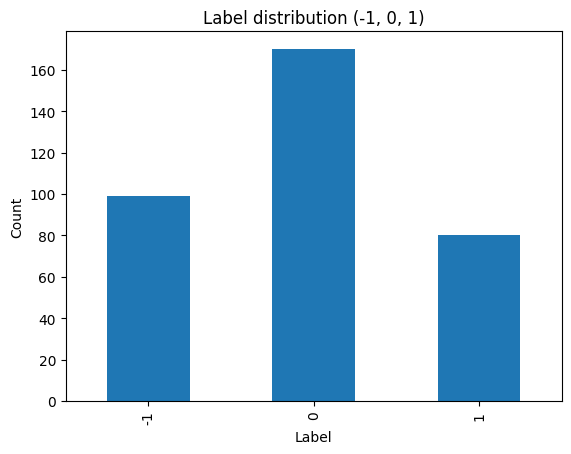

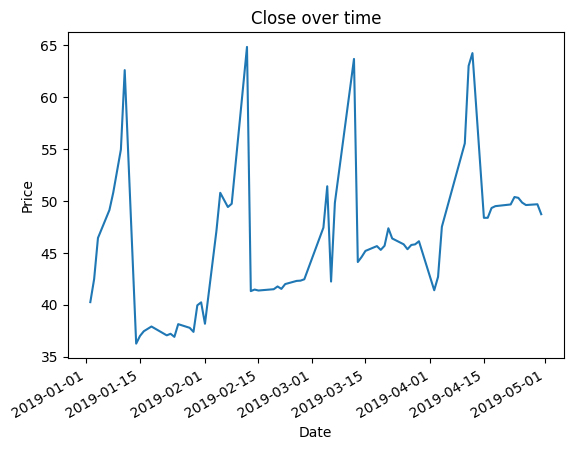

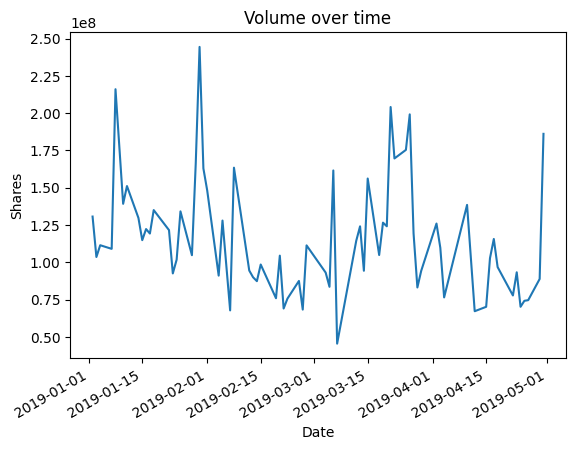

In [ ]:
# Descriptive stats for numeric columns
display(df[['Open','High','Low','Close','Volume']].describe())

# Add aux features
df['news_len'] = df['News'].astype(str).str.split().apply(len)

# Plots
df['news_len'].hist(bins=40); plt.title('News length (tokens)'); plt.xlabel('Tokens'); plt.ylabel('Count'); plt.show()

df['Label'].value_counts().sort_index().plot(kind='bar'); plt.title('Label distribution (-1, 0, 1)'); plt.xlabel('Label'); plt.ylabel('Count'); plt.show()

df.set_index('Date')['Close'].plot(); plt.title('Close over time'); plt.ylabel('Price'); plt.show()

df.set_index('Date')['Volume'].plot(); plt.title('Volume over time'); plt.ylabel('Shares'); plt.show()

### Bivariate Analysis

- Label vs price change
- Label vs volume

,mean,median,count
Label,,,
-1,-0.847680,0.0,98
0,0.700565,0.0,170
1,0.425297,0.0,80


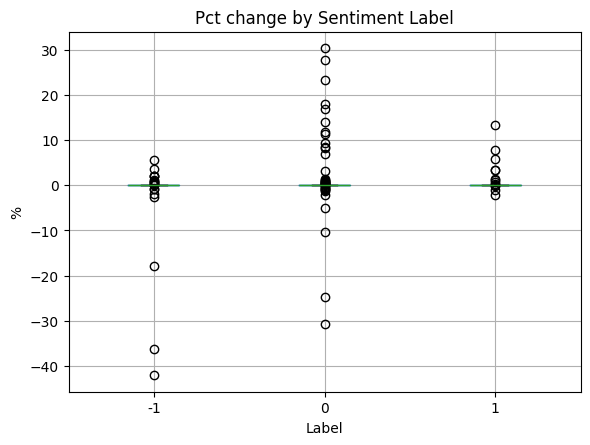

              Open      High       Low     Close    Volume  news_len
Open      1.000000  0.998526  0.997900  0.996273 -0.066532  0.098254
High      0.998526  1.000000  0.997328  0.997501 -0.045535  0.096306
Low       0.997900  0.997328  1.000000  0.998453 -0.103518  0.095431
Close     0.996273  0.997501  0.998453  1.000000 -0.079987  0.093788
Volume   -0.066532 -0.045535 -0.103518 -0.079987  1.000000 -0.000379
news_len  0.098254  0.096306  0.095431  0.093788 -0.000379  1.000000


In [ ]:
# Price change %
df['pct_change'] = df['Close'].pct_change()*100

# Group by label for insights
label_grp = df.groupby('Label')['pct_change'].agg(['mean','median','count'])
display(label_grp)

# Boxplots: pct_change by label
df.boxplot(column='pct_change', by='Label'); plt.title('Pct change by Sentiment Label'); plt.suptitle(''); plt.ylabel('%'); plt.show()

# Correlations
numerics = df[['Open','High','Low','Close','Volume','news_len']].corr()
print(numerics)

## **Text Preprocessing**

### Removing special characters from the text

In [ ]:
# defining a function to remove special characters
def remove_special_characters(text):
    # Defining the regex pattern to match non-alphanumeric characters
    pattern = '[^A-Za-z0-9]+'

    # Finding the specified pattern and replacing non-alphanumeric characters with a blank string
    new_text = ''.join(re.sub(pattern, ' ', text))

    return new_text

In [ ]:
# Applying the function to remove special characters
df['cleaned_text'] = df['News'].apply(remove_special_characters)

In [ ]:
# checking a couple of instances of cleaned data
df.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",The tech sector experienced a significant decline in the aftermarket following Apple s Q1 revenue warning Notable suppliers including Skyworks Broadcom Lumentum Qorvo and TSMC saw their stocks drop in response to Apple s downward revision of its revenue expectations for the quarter previously announced in January
1,"The dollar fell from above 109 to 106.67 after Apple's revenue warning, while the 10-year Treasury yield also dropped to 2.61%. This followed money flowing into US government paper. Apple's shares and U.S. stock index futures declined, with the NAS",The dollar fell from above 109 to 106 67 after Apple s revenue warning while the 10 year Treasury yield also dropped to 2 61 This followed money flowing into US government paper Apple s shares and U S stock index futures declined with the NAS
2,"In early Asian trading on Thursday, the Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning of sluggish iPhone sales in China and risk aversion. The yen reached its lowest levels against the U.S. dollar since March",In early Asian trading on Thursday the Japanese yen surged as the U S dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple s earnings warning of sluggish iPhone sales in China and risk aversion The yen reached its lowest levels against the U S dollar since March
3,"The Australian dollar experienced significant volatility on Thursday, plunging to multi-year lows against major currencies due to automated selling, liquidity issues, and a drought of trades. The largest intra-day falls in the Aussie's history occurred amid violent movements in AUD/JPY and AUD/",The Australian dollar experienced significant volatility on Thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades The largest intra day falls in the Aussie s history occurred amid violent movements in AUD JPY and AUD


### Lowercasing

In [ ]:
# changing the case of the text data to lower case
df['cleaned_text'] = df['cleaned_text'].str.lower()

In [ ]:
# checking a couple of instances of cleaned data
df.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"The dollar fell from above 109 to 106.67 after Apple's revenue warning, while the 10-year Treasury yield also dropped to 2.61%. This followed money flowing into US government paper. Apple's shares and U.S. stock index futures declined, with the NAS",the dollar fell from above 109 to 106 67 after apple s revenue warning while the 10 year treasury yield also dropped to 2 61 this followed money flowing into us government paper apple s shares and u s stock index futures declined with the nas
2,"In early Asian trading on Thursday, the Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning of sluggish iPhone sales in China and risk aversion. The yen reached its lowest levels against the U.S. dollar since March",in early asian trading on thursday the japanese yen surged as the u s dollar and australian dollar collapsed in thin markets due to massive stop loss sales triggered by apple s earnings warning of sluggish iphone sales in china and risk aversion the yen reached its lowest levels against the u s dollar since march
3,"The Australian dollar experienced significant volatility on Thursday, plunging to multi-year lows against major currencies due to automated selling, liquidity issues, and a drought of trades. The largest intra-day falls in the Aussie's history occurred amid violent movements in AUD/JPY and AUD/",the australian dollar experienced significant volatility on thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades the largest intra day falls in the aussie s history occurred amid violent movements in aud jpy and aud


### Removing extra whitespace

In [ ]:
# removing extra whitespaces from the text
df['cleaned_text'] = df['cleaned_text'].str.strip()

In [ ]:
# checking a couple of instances of cleaned data
df.loc[0:3, ['News','cleaned_text']]

,News,cleaned_text
0,"The tech sector experienced a significant decline in the aftermarket following Apple's Q1 revenue warning. Notable suppliers, including Skyworks, Broadcom, Lumentum, Qorvo, and TSMC, saw their stocks drop in response to Apple's downward revision of its revenue expectations for the quarter, previously announced in January.",the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january
1,"The dollar fell from above 109 to 106.67 after Apple's revenue warning, while the 10-year Treasury yield also dropped to 2.61%. This followed money flowing into US government paper. Apple's shares and U.S. stock index futures declined, with the NAS",the dollar fell from above 109 to 106 67 after apple s revenue warning while the 10 year treasury yield also dropped to 2 61 this followed money flowing into us government paper apple s shares and u s stock index futures declined with the nas
2,"In early Asian trading on Thursday, the Japanese yen surged as the U.S. dollar and Australian dollar collapsed in thin markets due to massive stop loss sales triggered by Apple's earnings warning of sluggish iPhone sales in China and risk aversion. The yen reached its lowest levels against the U.S. dollar since March",in early asian trading on thursday the japanese yen surged as the u s dollar and australian dollar collapsed in thin markets due to massive stop loss sales triggered by apple s earnings warning of sluggish iphone sales in china and risk aversion the yen reached its lowest levels against the u s dollar since march
3,"The Australian dollar experienced significant volatility on Thursday, plunging to multi-year lows against major currencies due to automated selling, liquidity issues, and a drought of trades. The largest intra-day falls in the Aussie's history occurred amid violent movements in AUD/JPY and AUD/",the australian dollar experienced significant volatility on thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades the largest intra day falls in the aussie s history occurred amid violent movements in aud jpy and aud


### Removing stopwords

In [ ]:
# defining a function to remove stop words using the NLTK library
def remove_stopwords(text):
    # Split text into separate words
    words = text.split()

    # Removing English language stopwords
    new_text = ' '.join([word for word in words if word not in stopwords.words('english')])

    return new_text

In [ ]:
# Applying the function to remove stop words using the NLTK library
df['cleaned_text_without_stopwords'] = df['cleaned_text'].apply(remove_stopwords)

In [ ]:
# checking a couple of instances of cleaned data
df.loc[0:3,['cleaned_text','cleaned_text_without_stopwords']]

,cleaned_text,cleaned_text_without_stopwords
0,the tech sector experienced a significant decline in the aftermarket following apple s q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo and tsmc saw their stocks drop in response to apple s downward revision of its revenue expectations for the quarter previously announced in january,tech sector experienced significant decline aftermarket following apple q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple downward revision revenue expectations quarter previously announced january
1,the dollar fell from above 109 to 106 67 after apple s revenue warning while the 10 year treasury yield also dropped to 2 61 this followed money flowing into us government paper apple s shares and u s stock index futures declined with the nas,dollar fell 109 106 67 apple revenue warning 10 year treasury yield also dropped 2 61 followed money flowing us government paper apple shares u stock index futures declined nas
2,in early asian trading on thursday the japanese yen surged as the u s dollar and australian dollar collapsed in thin markets due to massive stop loss sales triggered by apple s earnings warning of sluggish iphone sales in china and risk aversion the yen reached its lowest levels against the u s dollar since march,early asian trading thursday japanese yen surged u dollar australian dollar collapsed thin markets due massive stop loss sales triggered apple earnings warning sluggish iphone sales china risk aversion yen reached lowest levels u dollar since march
3,the australian dollar experienced significant volatility on thursday plunging to multi year lows against major currencies due to automated selling liquidity issues and a drought of trades the largest intra day falls in the aussie s history occurred amid violent movements in aud jpy and aud,australian dollar experienced significant volatility thursday plunging multi year lows major currencies due automated selling liquidity issues drought trades largest intra day falls aussie history occurred amid violent movements aud jpy aud


### Stemming

In [ ]:
# Loading the Porter Stemmer
ps = PorterStemmer()

In [ ]:
# defining a function to perform stemming
def apply_porter_stemmer(text):
    # Split text into separate words
    words = text.split()

    # Applying the Porter Stemmer on every word of a message and joining the stemmed words back into a single string
    new_text = ' '.join([ps.stem(word) for word in words])

    return new_text

In [ ]:
# Applying the function to perform stemming
df['final_cleaned_text'] = df['cleaned_text_without_stopwords'].apply(apply_porter_stemmer)

In [ ]:
# checking a couple of instances of cleaned data
df.loc[0:3,['cleaned_text_without_stopwords','final_cleaned_text']]

,cleaned_text_without_stopwords,final_cleaned_text
0,tech sector experienced significant decline aftermarket following apple q1 revenue warning notable suppliers including skyworks broadcom lumentum qorvo tsmc saw stocks drop response apple downward revision revenue expectations quarter previously announced january,tech sector experienc signific declin aftermarket follow appl q1 revenu warn notabl supplier includ skywork broadcom lumentum qorvo tsmc saw stock drop respons appl downward revis revenu expect quarter previous announc januari
1,dollar fell 109 106 67 apple revenue warning 10 year treasury yield also dropped 2 61 followed money flowing us government paper apple shares u stock index futures declined nas,dollar fell 109 106 67 appl revenu warn 10 year treasuri yield also drop 2 61 follow money flow us govern paper appl share u stock index futur declin na
2,early asian trading thursday japanese yen surged u dollar australian dollar collapsed thin markets due massive stop loss sales triggered apple earnings warning sluggish iphone sales china risk aversion yen reached lowest levels u dollar since march,earli asian trade thursday japanes yen surg u dollar australian dollar collaps thin market due massiv stop loss sale trigger appl earn warn sluggish iphon sale china risk avers yen reach lowest level u dollar sinc march
3,australian dollar experienced significant volatility thursday plunging multi year lows major currencies due automated selling liquidity issues drought trades largest intra day falls aussie history occurred amid violent movements aud jpy aud,australian dollar experienc signific volatil thursday plung multi year low major currenc due autom sell liquid issu drought trade largest intra day fall aussi histori occur amid violent movement aud jpi aud


## **Data Preprocessing**

In [ ]:
dataset = df.copy()

In [ ]:
X = df['final_cleaned_text'].copy()
y = df['Label']

# Initial split into training (80%) and testing (20%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.20, stratify=y, random_state=42)

# Further split the temporary set into validation (10%) and test (10%) sets
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.50, stratify=y_temp, random_state=42)

print(len(X_train), len(X_valid), len(X_test))

279 35 35


In [ ]:
print(X_train.shape, X_test.shape, X_valid.shape)

(279,) (35,) (35,)


In [ ]:
print(y_train.shape, y_test.shape, y_valid.shape)

(279,) (35,) (35,)


## **Word Embeddings**

### **Word2Vec**

In [ ]:
# Creating a list of all words in our data
words_list = [item.split(" ") for item in df['final_cleaned_text'].values]

In [ ]:
# Creating an instance of Word2Vec
vec_size = 300
model_W2V = Word2Vec(words_list, vector_size = vec_size, min_count = 1, window=5, workers = 6)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(list(model_W2V.wv.key_to_index)))

Length of the vocabulary is 2580


In [ ]:
def doc_embed_w2v(text, kv=model_W2V.wv, dim=100):
    toks = text.split()
    vecs = [kv[w] for w in toks if w in kv]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

def embed_corpus_w2v(corpus):
    return np.vstack([doc_embed_w2v(s) for s in corpus])

Xtr_w2v = embed_corpus_w2v(X_train)
Xva_w2v = embed_corpus_w2v(X_valid)
Xte_w2v = embed_corpus_w2v(X_test)
Xtr_w2v.shape, Xva_w2v.shape, Xte_w2v.shape

((279, 300), (35, 300), (35, 300))

### **GloVe**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# load the Stanford GloVe model
filename = '/content/drive/MyDrive/glove.6B.100d.txt.word2vec'
glove_model = KeyedVectors.load_word2vec_format(filename, binary=False)

In [ ]:
# Checking the size of the vocabulary
print("Length of the vocabulary is", len(glove_model.index_to_key))

Length of the vocabulary is 400000


In [ ]:
def doc_embed_glove(text, kv=glove_model, dim=100):
    toks = text.split()
    vecs = [kv[w] for w in toks if w in kv]
    if not vecs:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

def embed_corpus_glove(corpus):
    return np.vstack([doc_embed_glove(s) for s in corpus])

Xtr_glove = embed_corpus_glove(X_train)
Xva_glove = embed_corpus_glove(X_valid)
Xte_glove = embed_corpus_glove(X_test)
Xtr_glove.shape, Xva_glove.shape, Xte_glove.shape

((279, 100), (35, 100), (35, 100))

### **Sentence Transformer**

In [ ]:
st_model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# encoding the dataset
Xtr_st = st_model.encode(list(X_train), batch_size=64, show_progress_bar=True, device=device)
Xva_st = st_model.encode(list(X_valid), batch_size=64, show_progress_bar=True, device=device)
Xte_st = st_model.encode(list(X_test),  batch_size=64, show_progress_bar=True, device=device)
Xtr_st.shape, Xva_st.shape, Xte_st.shape

Batches:   0%|          | 0/5 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

((279, 384), (35, 384), (35, 384))

## **Modeling & Hyperparameter Tuning**

We'll test two lightweight classifiers:
- **Logistic Regression** (multinomial)
- **Linear SVM (LinearSVC)**

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_and_print(y_true, y_pred, title=""):
    print(f"\n=== {title} ===")
    print("Accuracy:", round(accuracy_score(y_true, y_pred), 4))
    print("Macro F1:", round(f1_score(y_true, y_pred, average='macro'), 4))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))
    cm = confusion_matrix(y_true, y_pred, labels=[-1,0,1])
    print("\nConfusion Matrix (rows=true, cols=pred, labels=[-1,0,1]):\n", cm)

# Hyperparameter spaces
logreg_params = {
    'C': np.logspace(-2, 2, 10),
    'penalty': ['l2'],
    'solver': ['lbfgs'],
    'max_iter': [500, 1000]
}

svm_params = {
    'C': np.logspace(-2, 2, 10),
    'loss': ['hinge', 'squared_hinge']
}

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV

def tune_and_eval(Xtr, ytr, Xva, yva, space, model_name="logreg"):
    if model_name == "logreg":
        base = LogisticRegression(multi_class='auto', random_state=42)
        search = RandomizedSearchCV(base, space, n_iter=12, scoring='f1_macro',
                                    cv=3, random_state=42, n_jobs=-1, verbose=0)
    else:
        base = LinearSVC(random_state=42)
        search = RandomizedSearchCV(base, space, n_iter=12, scoring='f1_macro',
                                    cv=3, random_state=42, n_jobs=-1, verbose=0)
    search.fit(Xtr, ytr)
    best = search.best_estimator_
    yhat = best.predict(Xva)
    evaluate_and_print(yva, yhat, title=f"{model_name} (best on validation)")
    return best

results = {}

# Word2Vec
print("Tuning on Word2Vec embeddings...")
best_lr_w2v = tune_and_eval(Xtr_w2v, y_train, Xva_w2v, y_valid, logreg_params, "logreg")
best_svm_w2v = tune_and_eval(Xtr_w2v, y_train, Xva_w2v, y_valid, svm_params, "svm")
results['w2v_lr'] = best_lr_w2v
results['w2v_svm'] = best_svm_w2v

# GloVe
print("\nTuning on GloVe embeddings...")
best_lr_glove = tune_and_eval(Xtr_glove, y_train, Xva_glove, y_valid, logreg_params, "logreg")
best_svm_glove = tune_and_eval(Xtr_glove, y_train, Xva_glove, y_valid, svm_params, "svm")
results['glove_lr'] = best_lr_glove
results['glove_svm'] = best_svm_glove

# Sentence-Transformer
print("\nTuning on Sentence-Transformer embeddings...")
best_lr_st = tune_and_eval(Xtr_st, y_train, Xva_st, y_valid, logreg_params, "logreg")
best_svm_st = tune_and_eval(Xtr_st, y_train, Xva_st, y_valid, svm_params, "svm")
results['st_lr'] = best_lr_st
results['st_svm'] = best_svm_st

Tuning on Word2Vec embeddings...

=== logreg (best on validation) ===
Accuracy: 0.4857
Macro F1: 0.2179

Classification Report:
               precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000        10
           0     0.4857    1.0000    0.6538        17
           1     0.0000    0.0000    0.0000         8

    accuracy                         0.4857        35
   macro avg     0.1619    0.3333    0.2179        35
weighted avg     0.2359    0.4857    0.3176        35


Confusion Matrix (rows=true, cols=pred, labels=[-1,0,1]):
 [[ 0 10  0]
 [ 0 17  0]
 [ 0  8  0]]

=== svm (best on validation) ===
Accuracy: 0.4571
Macro F1: 0.2092

Classification Report:
               precision    recall  f1-score   support

          -1     0.0000    0.0000    0.0000        10
           0     0.4706    0.9412    0.6275        17
           1     0.0000    0.0000    0.0000         8

    accuracy                         0.4571        35
   macro avg     0.1569    0

In [ ]:
from sklearn.metrics import f1_score

def macro_f1_on_valid(clf, Xva, yva):
    yhat = clf.predict(Xva)
    return f1_score(yva, yhat, average='macro')

candidates = {
    'w2v_lr': (results['w2v_lr'], Xva_w2v),
    'w2v_svm': (results['w2v_svm'], Xva_w2v),
    'glove_lr': (results['glove_lr'], Xva_glove),
    'glove_svm': (results['glove_svm'], Xva_glove),
    'st_lr': (results['st_lr'], Xva_st),
    'st_svm': (results['st_svm'], Xva_st),
}

best_name, best_clf, best_feats = None, None, None
best_score = -1.0
for name, (clf, Xva_) in candidates.items():
    score = macro_f1_on_valid(clf, Xva_, y_valid)
    print(f"{name}: val Macro F1 = {score:.4f}")
    if score > best_score:
        best_score = score
        best_name, best_clf, best_feats = name, clf, Xva_
print(f"\nBest model on validation: {best_name} (Macro F1={best_score:.4f})")

# Test-set features based on winner
if best_name.startswith('w2v'):
    Xte = Xte_w2v
elif best_name.startswith('glove'):
    Xte = Xte_glove
else:
    Xte = Xte_st

yhat_test = best_clf.predict(Xte)
evaluate_and_print(y_test, yhat_test, title=f"FINAL TEST — {best_name}")

w2v_lr: val Macro F1 = 0.2179
w2v_svm: val Macro F1 = 0.2092
glove_lr: val Macro F1 = 0.3821
glove_svm: val Macro F1 = 0.4254
st_lr: val Macro F1 = 0.4603
st_svm: val Macro F1 = 0.4520

Best model on validation: st_lr (Macro F1=0.4603)

=== FINAL TEST — st_lr ===
Accuracy: 0.4
Macro F1: 0.3515

Classification Report:
               precision    recall  f1-score   support

          -1     0.3125    0.5000    0.3846        10
           0     0.5714    0.4706    0.5161        17
           1     0.2000    0.1250    0.1538         8

    accuracy                         0.4000        35
   macro avg     0.3613    0.3652    0.3515        35
weighted avg     0.4126    0.4000    0.3957        35


Confusion Matrix (rows=true, cols=pred, labels=[-1,0,1]):
 [[5 4 1]
 [6 8 3]
 [5 2 1]]


### Summary

- Best model: Sentence-Transformer + Logistic Regression (st_lr)
- Validation Macro F1 = 0.4603 → best among all tested combinations.
- Trend:
  - Word2Vec-based models performed weakly (F1 ~0.21).
  - GloVe embeddings improved results (F1 ~0.38–0.42).
  - Sentence-Transformer embeddings clearly outperformed both, which makes sense since they capture semantic context much better.

## **Weekly News Summarization**

**Important Note**: It is recommended to run this section of the project independently from the previous sections in order to avoid runtime crashes due to RAM overload.

#### Installing and Importing the necessary libraries

In [2]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# Install uv package manager
!pip install uv

# Install llama-cpp-python with CUDA (T4 GPU → arch=75)
!CMAKE_ARGS="-DLLAMA_CUBLAS=on -DCMAKE_CUDA_ARCHITECTURES=75" FORCE_CMAKE=1 uv pip install --upgrade --force-reinstall llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu122

Using Python 3.12.11 environment at: /usr
Resolved 6 packages in 342ms
Prepared 6 packages in 42ms
Uninstalled 6 packages in 43ms
Installed 6 packages in 27ms
 ~ diskcache==5.6.3
 ~ jinja2==3.1.6
 ~ llama-cpp-python==0.3.16
 ~ markupsafe==3.0.2
 - numpy==1.26.4
 + numpy==2.3.2
 ~ typing-extensions==4.15.0


In [13]:
# Function to download the model from the Hugging Face model hub
from huggingface_hub import hf_hub_download

# Importing the Llama class from the llama_cpp module
from llama_cpp import Llama

# Importing the library for data manipulation
import pandas as pd

from tqdm import tqdm # For progress bar related functionalities
tqdm.pandas()

RuntimeError: Failed to load shared library '/usr/local/lib/python3.12/dist-packages/llama_cpp/lib/libllama.so': libcuda.so.1: cannot open shared object file: No such file or directory

#### Loading the data

In [9]:
df = pd.read_csv("/content/sample_data/stock_news.csv")

#### Loading the model

In [10]:
model_name_or_path = "TheBloke/Llama-2-13B-chat-GGUF"
model_basename = "llama-2-13b-chat.Q5_K_M.gguf" # the model is in gguf format

In [11]:
model_path = hf_hub_download(
     repo_id=model_name_or_path,
     filename=model_basename
)

llama-2-13b-chat.Q5_K_M.gguf:   0%|          | 0.00/9.23G [00:00<?, ?B/s]

In [12]:
lcpp_llm = Llama(
    model_path=model_path,
    n_threads=2,  # CPU cores
    n_batch=512,  # Should be between 1 and n_ctx, consider the amount of VRAM in your GPU.
    # n_gpu_layers=43,  # uncomment and change this value based on GPU VRAM pool.
    n_ctx=4096,  # Context window
)

NameError: name 'Llama' is not defined

### Loading the model (Mistral)

In [34]:
model_name_or_path = "TheBloke/Mistral-7B-Instruct-v0.2-GGUF"
model_basename = "mistral-7b-instruct-v0.2.Q6_K.gguf"

In [35]:
model_path = hf_hub_download(
    repo_id=model_name_or_path,
    filename=model_basename
)

mistral-7b-instruct-v0.2.Q6_K.gguf:   0%|          | 0.00/5.94G [00:00<?, ?B/s]

In [36]:
llm = Llama(
    model_path=model_path,
    n_ctx=1024,
)

llama_model_load_from_file_impl: using device CUDA0 (Tesla T4) - 14544 MiB free
llama_model_loader: loaded meta data with 24 key-value pairs and 291 tensors from /root/.cache/huggingface/hub/models--TheBloke--Mistral-7B-Instruct-v0.2-GGUF/snapshots/3a6fbf4a41a1d52e415a4958cde6856d34b2db93/mistral-7b-instruct-v0.2.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str              = llama
llama_model_loader: - kv   1:                               general.name str              = mistralai_mistral-7b-instruct-v0.2
llama_model_loader: - kv   2:                       llama.context_length u32              = 32768
llama_model_loader: - kv   3:                     llama.embedding_length u32              = 4096
llama_model_loader: - kv   4:                          llama.block_count u32              = 32
llama_model_loader: - kv   5:      

### Defining Model Response Parameters

In [37]:
def generate_llama_response(instruction, review):

    # System message explicitly instructing not to include the review text
    system_message = """
        [INST]<<SYS>>
        {}
        <</SYS>>[/INST]
    """.format(instruction)

    # Combine user_prompt and system_message to create the prompt
    prompt = f"{review}\n{system_message}"

    # Generate a response from the LLaMA model
    response = lcpp_llm(
        prompt=prompt,
        max_tokens=1024,
        temperature=0,
        top_p=0.95,
        repeat_penalty=1.2,
        top_k=50,
        stop=['INST'],
        echo=False,
        seed=42,
    )

    # Extract the sentiment from the response
    response_text = response["choices"][0]["text"]
    return response_text

### Utility function

In [38]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_sentiment = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_sentiment)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

## Aggregating the data weekly

In [39]:
df["Date"] = pd.to_datetime(df['Date'])  # Convert the 'Date' column to datetime format.

In [40]:
# Group the data by week using the 'Date' column.
weekly_grouped = df.groupby(pd.Grouper(key='Date', freq='W'))

In [41]:
weekly_grouped = weekly_grouped.agg(
    {
        'News': lambda x: ' || '.join(x)  # Join the news values with ' || ' separator.
    }
).reset_index()

print(weekly_grouped.shape)

(18, 2)


In [42]:
weekly_grouped

Date  \
0  2019-01-06   
1  2019-01-13   
2  2019-01-20   
3  2019-01-27   
4  2019-02-03   
5  2019-02-10   
6  2019-02-17   
7  2019-02-24   
8  2019-03-03   
9  2019-03-10   
10 2019-03-17   
11 2019-03-24   
12 2019-03-31   
13 2019-04-07   
14 2019-04-14   
15 2019-04-21   
16 2019-04-28   
17 2019-05-05   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## 1. Sentiment Analysis (Llama)

In [2]:
# creating a copy of the data
weekly_summary_df = weekly_grouped.copy()

NameError: name 'weekly_grouped' is not defined

In [47]:
# defining the instructions for the model
instruction_1 = (
    "You are a financial news analyst. "
    "From the weekly news headlines, extract the top 3 POSITIVE events "
    "and the top 3 NEGATIVE events that are likely to impact the stock price. "
    "Present them in a structured bullet-point format."
)

In [1]:
weekly_summary_df['positive_events'] = weekly_summary_df['summary'].str.extract(r'Positive events:(.*)Negative', expand=False)
weekly_summary_df['negative_events'] = weekly_summary_df['summary'].str.extract(r'Negative events:(.*)', expand=False)

NameError: name 'weekly_summary_df' is not defined

In [49]:
weekly_summary_df.head()

Date  \
0 2019-01-06   
1 2019-01-13   
2 2019-01-20   
3 2019-01-27   
4 2019-02-03   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

#### Summarization

**Note**:

- The model is expected to summarize the news from the week by identifying the top three positive and negative events that are most likely to impact the price of the stock.

- As an output, the model is expected to return a JSON containing two keys, one for Positive Events and one for Negative Events.

For the project, we need to define the prompt to be fed to the LLM to help it understand the task to perform. The following should be the components of the prompt:

1. **Role**: Specifies the role the LLM will be taking up to perform the specified task, along with any specific details regarding the role

  - **Example**: `You are an expert data analyst specializing in news content analysis.`

2. **Task**: Specifies the task to be performed and outlines what needs to be accomplished, clearly defining the objective

  - **Example**: `Analyze the provided news headline and return the main topics contained within it.`

3. **Instructions**: Provides detailed guidelines on how to perform the task, which includes steps, rules, and criteria to ensure the task is executed correctly

  - **Example**:

```
Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.
```

4. **Output Format**: Specifies the format in which the final response should be structured, ensuring consistency and clarity in the generated output

  - **Example**: `Return the output in JSON format with keys as the topic number and values as the actual topic.`

**Full Prompt Example**:

```
You are an expert data analyst specializing in news content analysis.

Task: Analyze the provided news headline and return the main topics contained within it.

Instructions:
1. Read the news headline carefully.
2. Identify the main subjects or entities mentioned in the headline.
3. Determine the key events or actions described in the headline.
4. Extract relevant keywords that represent the topics.
5. List the topics in a concise manner.

Return the output in JSON format with keys as the topic number and values as the actual topic.
```

**Sample Output**:

`{"1": "Politics", "2": "Economy", "3": "Health" }`

##### Utility Functions

In [ ]:
# defining a function to parse the JSON output from the model
def extract_json_data(json_str):
    import json
    try:
        # Find the indices of the opening and closing curly braces
        json_start = json_str.find('{')
        json_end = json_str.rfind('}')

        if json_start != -1 and json_end != -1:
            extracted_category = json_str[json_start:json_end + 1]  # Extract the JSON object
            data_dict = json.loads(extracted_category)
            return data_dict
        else:
            print(f"Warning: JSON object not found in response: {json_str}")
            return {}
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return {}

##### Defining the response function

In [ ]:
#Defining the response function
def response_mistral_1(prompt, news):
    model_output = llm(
      f"""
      [INST]
      {prompt}
      News Articles: {news}
      [/INST]
      """,
      max_tokens=_____, #Complete the code to set the maximum number of tokens the model should generate for this task.
      temperature=_____, #Complete the code to set the value for temperature.
      top_p=_____, #Complete the code to set the value for top_p
      top_k=_____, #Complete the code to set the value for top_k
      echo=False,
    )

    final_output = model_output["choices"][0]["text"]

    return final_output

##### Checking the model output on a sample

**Note**: Use this section to test out the prompt with one instance before using it for the entire weekly data.

##### Checking the model output on the weekly data

##### Formatting the model output

## **Conclusions and Recommendations**

-




<font size=6 color='blue'>Power Ahead</font>
___